**Installing Dependencies**

In [ ]:
pip install sentence_transformers huggingface langchain langchain_community pinecone pinecone-client pinecone-notebooks pypdf langchain-huggingface chromadb rank_bm25

In [ ]:
pip install langchain-groq

**Loading HuggingFace Token**

**Loading Sentence Transformer Model for embeddings**

In [ ]:
from dotenv import load_dotenv
load_dotenv()
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
embeddings

**Loading Documents using PyPDF Loader**

Dataset is cardiology textbook as a pdf file

In [6]:
from langchain_community.document_loaders import PyPDFLoader
docpath = "/content/drive/MyDrive/VectorSave/cardiology/cardiology-explained.pdf"
loader = PyPDFLoader(docpath)

In [7]:
docs = loader.load()

In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores.chroma import Chroma

In [9]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500 ,chunk_overlap=100)
chunks = text_splitter.split_documents(docs)
len(chunks)

1060

**Using Chroma as a Vectorstore**

Chroma will handle indexing of documents using HNSW by default.

At first i am not going to create chunks. I want the to load pages instead of chunks.
So pages will be embedded and indexed in the vector store.
By default Chroma uses L2 metrics.

In [10]:
from langchain.vectorstores import Chroma
vectorstore = Chroma.from_documents(chunks, embeddings)

**Creating the Retrievers**

***BM25Retriever*** for keyword based search TF-IDF

***Vectorstore Retriever ***will perform the Embedding vector based retrieval

k is set to 3 to retriver top 3 documents

In [11]:
from langchain_community.retrievers import BM25Retriever
keyword_retriever = BM25Retriever.from_documents(chunks, k=3)     # BM25 will be the keyword retriver or sparse retriever
vectorstore_retriever = vectorstore.as_retriever(search_kwargs={"k": 3})    # Dense Vector embeddings will be retrived using vectorstore retriever
                                                                            # k is set to 3 as it will retrieve top 3 documents

**Ensemble Retriever**

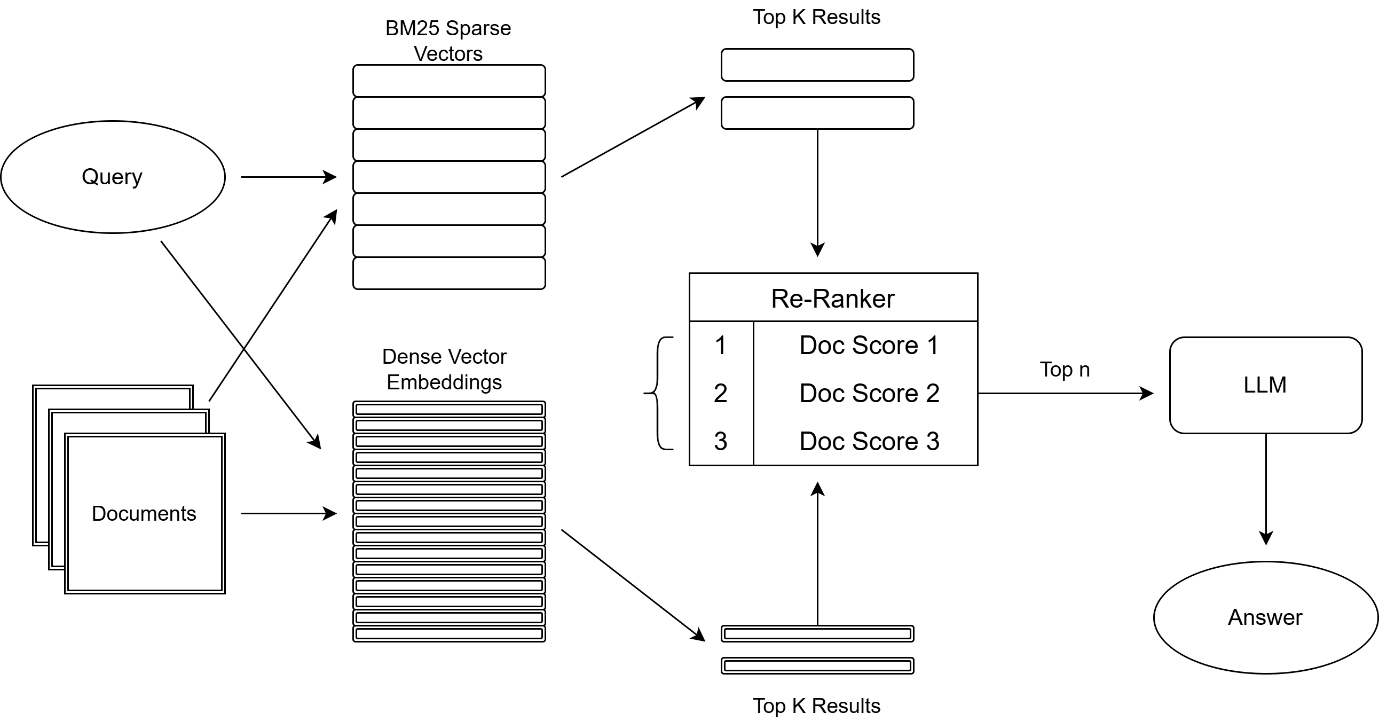

hybrid_score  =  [ (1-alpha) * sparse_score ] + [ alpha * dense_score ]

The score derived from the hybrid search is called  ***hybrid_score***.

The score derived from the independent vector search is  ***vector_score*** in this case referred to as ***sparse_score*** and
 ***dense_score***.

Each score is given a weight based on alpha, which normally ranges from 0 to 1.

Alpha = 1 : Search using just vectors

Alpha = 0 : Search using only keywords


In [13]:
from langchain.retrievers.ensemble import EnsembleRetriever         # Ensemble Retriver

ensemble_retriever = EnsembleRetriever(retrievers=[vectorstore_retriever,
                                                   keyword_retriever],
                                       weights=[0.7, 0.3])                # Alpha values or weights be assigned as 0.7 and 0.3 for this use-case

In [ ]:
import nltk         #installing more dependencies
nltk.download('punkt_tab')

**Retrieving Documents based on similarity search using BM25 and Dense Vectors**

In [15]:
bm25_result = keyword_retriever.invoke("what is a heart murmur")

In [16]:
dpr_result = vectorstore_retriever.invoke("what is a heart murmur")

**Creating a Pretty Print Function to format the results**

***get_source_info :*** this will get the source of the documents which in this case is going to be cardiology explained textbook

***get_page_number :*** this will extract the page number from the metadata

And finally we will print the ***page content*** upto 100 characters

In [17]:
import os

def pretty_print_docs(res):
    def get_source_info(document):    #  Retrieve the file name from the document's metadata.
        source = document.metadata.get("source", "Unknown Source") if hasattr(document, 'metadata') else "Unknown Source"
        return os.path.basename(source)  # Extracting the file name using os.path.basename

    def get_page_number(document):    #  Retrieve page number information from the document's metadata.
        return document.metadata.get("page", "Unknown Page") if hasattr(document, 'metadata') else "Unknown Page"

    print(
        f"\n{'-' * 100}\n".join(
            [
                f"Document {i+1}:\n\nSource: {get_source_info(d)}\nPage: {get_page_number(d)}\n\n" + d.page_content
                for i, d in enumerate(res)
            ]
        )
    )

**Top Documents Retrieved by BM25**

In [18]:
pretty_print_docs(bm25_result)

Document 1:

Source: cardiology-explained.pdf
Page: 177

constitutional symptoms such as fever, rigors, night sweats, anorexia, weight loss,
or arthralgia. 
Cardiac signs
The presence of a new murmur is very significant, as is a change in the nature
of an existing murmur (a regurgitant murmur may disappear on worsening).
Myocardial involvement or valvular dysfunction may both contribute to left
ventricular failure.
Skin lesions
Endocarditis is indicated by:
• Osler’s nodes – tender lesions found on finger pulps
----------------------------------------------------------------------------------------------------
Document 2:

Source: cardiology-explained.pdf
Page: 118

remains that while cancer patients receive end-of-life support and often report
dyspnea as an equivalent problem to pain, many more heart failure patients whose
chief symptom is dyspnea have a poorer prognosis and go unattended. The
management of these patients is an area deserving of more investigation and
analysis. For ex

**Top Documents Retrieved by Dense Vector Search**

In [19]:
pretty_print_docs(dpr_result)

Document 1:

Source: cardiology-explained.pdf
Page: 155

pleasures in clinical medicine than having your stethoscopic diagnostic brilliance
confirmed by an echo report. Furthermore, healthcare economics has prompted a
renewed interest in the power of the stethoscope for diagnosing and even
quantifying valve disease.
The asymptomatic murmur
Opinions differ as to the management of a murmur that has been picked up
incidentally. By far the most common is the mid systolic 2/6 murmur (grade II –
----------------------------------------------------------------------------------------------------
Document 2:

Source: cardiology-explained.pdf
Page: 21

Cardiovascular examination
11
Murmurs
When you have considered these heart sound variations, move on to consider the
gaps between the heart sounds. If you hear a murmur, first establish whether 
it occurs in systole or diastole (time against the carotid pulse if necessary). Then
determine its length and, if short, its exact position (early, mid, 

**Creating the Reciprocal Rank Fusion Function using the formula:**


*RRF(d∈D)=∑_(r∈R)▒1/(k+r(d))*

where :

    d is the document retrieved

    k is a constant (usually 60)

    r(d) is the rank of document d in retriever rank r

The previous cell with the `reciprocal_rank_fusion` function could not be fixed directly due to dependency conflicts. A new cell is being created with the corrected function.

In [23]:
from json import dumps, loads
from langchain_core.documents import Document  # Import Document from the correct location

def reciprocal_rank_fusion(results: list, k=60):
    flattened_results = results
    fused_scores = {}
    for rank, doc in enumerate(flattened_results):
        doc_dict = doc.__dict__
        doc_str = dumps(doc_dict)
        if doc_str not in fused_scores:
            fused_scores[doc_str] = 0
        fused_scores[doc_str] += 1 / (rank + k)

    reranked_results = [
        (Document(**loads(doc)), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    print("Reranked documents: ", len(reranked_results))
    for doc in reranked_results:
        print('---')
        print('Docs: ', ' '.join(doc[0].page_content[:100].split()))
        print('RRF score: ', doc[1])

    return [x[0] for x in reranked_results]

Retrieve Documents using ensemble retriever

In [24]:
ensemble_result = ensemble_retriever.invoke("what is a heart murmur")

In [25]:
pretty_print_docs(ensemble_result)

Document 1:

Source: cardiology-explained.pdf
Page: 155

pleasures in clinical medicine than having your stethoscopic diagnostic brilliance
confirmed by an echo report. Furthermore, healthcare economics has prompted a
renewed interest in the power of the stethoscope for diagnosing and even
quantifying valve disease.
The asymptomatic murmur
Opinions differ as to the management of a murmur that has been picked up
incidentally. By far the most common is the mid systolic 2/6 murmur (grade II –
----------------------------------------------------------------------------------------------------
Document 2:

Source: cardiology-explained.pdf
Page: 21

Cardiovascular examination
11
Murmurs
When you have considered these heart sound variations, move on to consider the
gaps between the heart sounds. If you hear a murmur, first establish whether 
it occurs in systole or diastole (time against the carotid pulse if necessary). Then
determine its length and, if short, its exact position (early, mid, 

**Applying RRF to the ensemble results**

In [26]:
reciprocal_rank_fusion(ensemble_result)

Reranked documents:  6
---
Docs:  pleasures in clinical medicine than having your stethoscopic diagnostic brilliance confirmed by an e
RRF score:  0.016666666666666666
---
Docs:  Cardiovascular examination 11 Murmurs When you have considered these heart sound variations, move on
RRF score:  0.01639344262295082
---
Docs:  physical examination technique. Am Heart J 2001;141:500–6. Shry EA, Smithers MA, Mascette AM. Auscul
RRF score:  0.016129032258064516
---
Docs:  constitutional symptoms such as fever, rigors, night sweats, anorexia, weight loss, or arthralgia.
RRF score:  0.015873015873015872
---
Docs:  remains that while cancer patients receive end-of-life support and often report dyspnea as an equiva
RRF score:  0.015625
---
Docs:  mechanisms of cardiovascular disease in a straightforward and diagrammatic manner, gives guidelines
RRF score:  0.015384615384615385


[Document(metadata={'source': '/content/drive/MyDrive/VectorSave/cardiology/cardiology-explained.pdf', 'moddate': '2008-03-09T20:55:00-05:00', 'producer': 'Acrobat Distiller 4.05 for Macintosh', 'title': '1340 Cardiology Explained 3', 'total_pages': 257, 'creationdate': '2004-12-20T15:41:23+00:00', 'page': 155, 'creator': 'QuarkXPress(tm) 4.11', 'page_label': '145'}, page_content='pleasures in clinical medicine than having your stethoscopic diagnostic brilliance\nconfirmed by an echo report. Furthermore, healthcare economics has prompted a\nrenewed interest in the power of the stethoscope for diagnosing and even\nquantifying valve disease.\nThe asymptomatic murmur\nOpinions differ as to the management of a murmur that has been picked up\nincidentally. By far the most common is the mid systolic 2/6 murmur (grade II –'),
 Document(metadata={'source': '/content/drive/MyDrive/VectorSave/cardiology/cardiology-explained.pdf', 'page': 21, 'moddate': '2008-03-09T20:55:00-05:00', 'producer': 'A

**Re-Ranking Using Cross Encoder**

Cross Encoder requires a pair of documents to compare them.

In our use-case we are going to use query and the retrieved documents and store in the pairs variable.

scores : the cross encoder will output logit scores for every query document pair based on similarity relevance. These are logit scores which are not normalized but can be done to get a proper score between 0-1 range. I am not going to do that because we are already getting a logit score which can just be printed in decending order to rank the documents.

In [27]:
from sentence_transformers import CrossEncoder

def get_relevance_scores(question, documents):
    ce = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=512)
    pairs = [[question, doc.page_content] for doc in documents]
    scores = ce.predict(pairs)
    return scores

Getting scores for dense vector results

In [ ]:
get_relevance_scores("what is a heart murmur", dpr_result)

Getting scores for ensemble results

In [29]:
get_relevance_scores("what is a heart murmur", ensemble_result)

array([ -7.0344043,   3.2254393,  -3.1819134,  -1.121712 , -10.673525 ,
       -10.451581 ], dtype=float32)

Re-ordering the documents along with their logit score in descending order to get the highest ranked document at the top.
To make it understandable, the relevant meta-data like source and page number will also be printed alongside the content

In [30]:
def sort_and_display_documents(scores, documents, display_limit=200):

    # Pair scores with documents
    scored_docs = [(score, doc) for score, doc in zip(scores, documents)]

    # Sort by scores in descending order
    sorted_docs = sorted(scored_docs, key=lambda x: x[0], reverse=True)

    # Extract the reordered documents
    reordered_docs = [doc for _, doc in sorted_docs]

    # Print scores, source, page numbers, document content
    print("Documents Sorted by Scores:\n")
    for score, doc in sorted_docs:
        # Extract file name from source path
        source_file_name = os.path.basename(doc.metadata.get('source', 'N/A'))

        print(f"Score: {score}, \nSource: {source_file_name}, Page: {doc.metadata.get('page', 'N/A')}, \nDoc:\n{doc.page_content[:display_limit]}\n\n")

    return reordered_docs

In [32]:
from langchain_core.output_parsers import StrOutputParser

In [33]:
def get_highest_ranked_document(scores, documents):

    if scores.size == 0 or not documents or len(scores) != len(documents):
        raise ValueError("Scores and documents must be non-empty and of the same length.")

    # Pair scores with documents and find the maximum by score
    highest_ranked = max(zip(scores, documents), key=lambda x: x[0])

    # Return the document with the highest score
    return highest_ranked[1]

In [34]:
def get_best_doc(question, documents):
    scores = get_relevance_scores(question, documents)
    return get_highest_ranked_document(scores, documents)

In [55]:
def full_retrieval(question):
    docs = ensemble_retriever.invoke(question)
    best_doc = get_best_doc(question, docs)
    return best_doc

In [95]:
from langchain_groq import ChatGroq

groqllm=ChatGroq(groq_api_key=userdata.get('GROQ'),
                 model_name= "groq/compound")

In [96]:
from langchain_core.prompts import PromptTemplate
gqtemplate = """Answer the question :
{question}
Based on the following context :
{context}

"""
gqprompt = PromptTemplate(
    template=gqtemplate,
    input_variables=["context", "question"],  # The context will be the top retrieved document and the question is the user query

)

In [97]:
llm_prompt_template = """Answer only the question :
{question}

"""
llm_prompt = PromptTemplate(
    template=llm_prompt_template,
    input_variables=["question"],

)

In [98]:
groqchain = gqprompt | groqllm | StrOutputParser()
only_llm_chain = llm_prompt | groqllm

In [99]:
groqchain = gqprompt | groqllm | StrOutputParser()
only_llm_chain = llm_prompt | groqllm

In [100]:
def only_llm_test(question):
  result = only_llm_chain.invoke({"question": question})
  return result

In [101]:
def groq_test(question):
  result = groqchain.invoke({"context": full_retrieval(question), "question": question})
  return result

In [102]:
only_llm_chain.invoke({"question": "what is a heart murmur"})

AIMessage(content='A heart murmur is a sound made by turbulent blood flow within the heart or its valves, heard with a stethoscope.', additional_kwargs={'reasoning_content': '<Think>\n\n</Think>'}, response_metadata={'token_usage': {'completion_tokens': 78, 'prompt_tokens': 254, 'total_tokens': 332, 'completion_time': 0.164347, 'prompt_time': 0.008405, 'queue_time': 0.04419, 'total_time': 0.172752}, 'model_name': 'groq/compound', 'system_fingerprint': None, 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--dad3b3fd-ddca-480b-8c1f-094f0d2e152c-0', usage_metadata={'input_tokens': 254, 'output_tokens': 78, 'total_tokens': 332})

In [103]:
heart_murmur = only_llm_test("what is a heart murmur")

In [104]:
print(heart_murmur)

content='A heart murmur is a sound made by turbulent blood flow within the heart or its nearby vessels, heard with a stethoscope. It can be harmless (innocent) or indicate an underlying heart condition.' additional_kwargs={'reasoning_content': '<Think>\n\n</Think>'} response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 254, 'total_tokens': 341, 'completion_time': 0.184404, 'prompt_time': 0.008331, 'queue_time': 0.161946, 'total_time': 0.192735}, 'model_name': 'groq/compound', 'system_fingerprint': None, 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'} id='lc_run--a01322d1-3f8d-4343-9fb7-57465a35510c-0' usage_metadata={'input_tokens': 254, 'output_tokens': 87, 'total_tokens': 341}


In [105]:
heart_res = groq_test("what is a heart murmur")

In [106]:
heart_res

'**What is a heart murmur?**\n\nA heart murmur is an **extra or abnormal sound** that can be heard with a stethoscope during the cardiac cycle.  \n- It is usually described as a **whooshing, swishing, humming, or rasping** noise.  \n- The sound is produced when **blood flows turbulently** through the heart or its valves rather than the normal smooth (laminar) flow.  \n\nMurmurs may be:\n\n| Type | Typical significance |\n|------|----------------------|\n| **Innocent (functional) murmur** | Harmless; common in children and healthy adults; requires no treatment. |\n| **Pathologic (abnormal) murmur** | Indicates an underlying cardiac problem such as valve stenosis, regurgitation, congenital defects, infection, or other disease; further evaluation (e.g., echocardiography) is needed. |\n\n**How it relates to the provided context**\n\n- The passage mentions a **“classic ejection systolic murmur”** heard best over the aortic area, which radiates to the carotids and is typical of **aortic sten

**Re-Ranked Dense Vector Results using Cross Encoder**

In [58]:
sort_and_display_documents(get_relevance_scores("what is a heart murmur", dpr_result), dpr_result)

Documents Sorted by Scores:

Score: 3.2254395484924316, 
Source: cardiology-explained.pdf, Page: 21, 
Doc:
Cardiovascular examination
11
Murmurs
When you have considered these heart sound variations, move on to consider the
gaps between the heart sounds. If you hear a murmur, first establish whether 
it oc


Score: -3.1819114685058594, 
Source: cardiology-explained.pdf, Page: 175, 
Doc:
physical examination technique. Am Heart J 2001;141:500–6.
Shry EA, Smithers MA, Mascette AM. Auscultation versus echocardiography in a healthy
population with precordial murmur. Am J Cardiol 2001;87:


Score: -7.03440523147583, 
Source: cardiology-explained.pdf, Page: 155, 
Doc:
pleasures in clinical medicine than having your stethoscopic diagnostic brilliance
confirmed by an echo report. Furthermore, healthcare economics has prompted a
renewed interest in the power of the st




[Document(metadata={'page_label': '11', 'title': '1340 Cardiology Explained 3', 'creationdate': '2004-12-20T15:41:23+00:00', 'page': 21, 'creator': 'QuarkXPress(tm) 4.11', 'total_pages': 257, 'moddate': '2008-03-09T20:55:00-05:00', 'source': '/content/drive/MyDrive/VectorSave/cardiology/cardiology-explained.pdf', 'producer': 'Acrobat Distiller 4.05 for Macintosh'}, page_content='Cardiovascular examination\n11\nMurmurs\nWhen you have considered these heart sound variations, move on to consider the\ngaps between the heart sounds. If you hear a murmur, first establish whether \nit occurs in systole or diastole (time against the carotid pulse if necessary). Then\ndetermine its length and, if short, its exact position (early, mid, or late; systole or\ndiastole) (see \nFigure 3). \nAdded sounds \nAn opening snap occurring after the second heart sound represents a diseased'),
 Document(metadata={'page_label': '165', 'total_pages': 257, 'producer': 'Acrobat Distiller 4.05 for Macintosh', 'titl

**Re-Ranked Ensemble Retrieved Documents using Cross Encoder**

In [59]:
sort_and_display_documents(get_relevance_scores("what is a heart murmur", ensemble_result), ensemble_result)

Documents Sorted by Scores:

Score: 3.2254393100738525, 
Source: cardiology-explained.pdf, Page: 21, 
Doc:
Cardiovascular examination
11
Murmurs
When you have considered these heart sound variations, move on to consider the
gaps between the heart sounds. If you hear a murmur, first establish whether 
it oc


Score: -1.1217119693756104, 
Source: cardiology-explained.pdf, Page: 177, 
Doc:
constitutional symptoms such as fever, rigors, night sweats, anorexia, weight loss,
or arthralgia. 
Cardiac signs
The presence of a new murmur is very significant, as is a change in the nature
of an e


Score: -3.181913375854492, 
Source: cardiology-explained.pdf, Page: 175, 
Doc:
physical examination technique. Am Heart J 2001;141:500–6.
Shry EA, Smithers MA, Mascette AM. Auscultation versus echocardiography in a healthy
population with precordial murmur. Am J Cardiol 2001;87:


Score: -7.034404277801514, 
Source: cardiology-explained.pdf, Page: 155, 
Doc:
pleasures in clinical medicine than having you

[Document(metadata={'source': '/content/drive/MyDrive/VectorSave/cardiology/cardiology-explained.pdf', 'page': 21, 'moddate': '2008-03-09T20:55:00-05:00', 'producer': 'Acrobat Distiller 4.05 for Macintosh', 'creator': 'QuarkXPress(tm) 4.11', 'page_label': '11', 'title': '1340 Cardiology Explained 3', 'total_pages': 257, 'creationdate': '2004-12-20T15:41:23+00:00'}, page_content='Cardiovascular examination\n11\nMurmurs\nWhen you have considered these heart sound variations, move on to consider the\ngaps between the heart sounds. If you hear a murmur, first establish whether \nit occurs in systole or diastole (time against the carotid pulse if necessary). Then\ndetermine its length and, if short, its exact position (early, mid, or late; systole or\ndiastole) (see \nFigure 3). \nAdded sounds \nAn opening snap occurring after the second heart sound represents a diseased'),
 Document(metadata={'producer': 'Acrobat Distiller 4.05 for Macintosh', 'creator': 'QuarkXPress(tm) 4.11', 'creationda

**Trying Pinecone Hybrid Search with Dot-Product**

In [61]:
from pinecone import Pinecone, ServerlessSpec         #Pinecone Configuration
pc = Pinecone(api_key=PCKEY)
import os
cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

In [ ]:
from google.colab import userdata
userdata.get('pinecone')

**Creating the pinecone index**

Indexing process in Pinecone is by default HNSW.

We will use Dot Product metrics this time as both embeddings are un-normalized.

Dimesnions = 384 : The embedding dimensions using our sentence transformer mini are 384 so the index dimension is also 384. If using a bigger model the dimensions have to be adjusted according to the shape of embeddings.

In [108]:
import os
from pinecone import Pinecone, ServerlessSpec

index_name = "langchain-pinecone-hybrid-search"
pc = Pinecone(api_key=userdata.get('pinecone'))

# delete the index if it exists
if index_name in pc.list_indexes().names():
    pc.delete_index(index_name)

pc.create_index(
    name=index_name,
    dimension=384,      #dimensions are 384 because of the embedding model dimension. It can change based on different embedding models
    metric="dotproduct", # metric as dotproduct for hybrid search
    spec=ServerlessSpec(cloud="aws", region="us-east-1"),
)

index = pc.Index(index_name)

In [ ]:
index = pc.Index(index_name)
index

In [ ]:
pip install pinecone-text

I will be chunking the documents this time using Recursive Character Text Splitter.

Chunk size is 800 and overlap is 100 because thats what i have noticed being used by default in different use-cases.

In [65]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=800,
                                          chunk_overlap=100)
chunks = splitter.split_documents(docs)

Loading BM25 Encoder for TF-IDF values. SPLADE can also be used as it is an improved version of BM25. But i will be using default because this use-case is TF-IDF based.

In [ ]:
from pinecone_text.sparse import BM25Encoder
# use default tf-idf values
bm25_encoder = BM25Encoder().default()

Adding Chunks to the BM25 endcoder to get the sparse vectors

In [ ]:
# Extracting string from document object
corpus = [doc.page_content for doc in chunks]

# Now fit the BM25Encoder using the corpus of strings
bm25_encoder.fit(corpus)

In [68]:
# store the values to json file
bm25_encoder.dump("bm25_values.json")

# load to BM25Encoder object
bm25_encoder = BM25Encoder().load("bm25_values.json")

**Loading the Hybrid Search Retriever**

In [69]:
from langchain_community.retrievers import PineconeHybridSearchRetriever
Ens_PC_retriever = PineconeHybridSearchRetriever(embeddings = embeddings,
                                         sparse_encoder = bm25_encoder,
                                         index = index)

In [ ]:
Ens_PC_retriever.add_texts(corpus)  # Adding chunks

**Retrieving Documents using Ensemble Dot Product Retriever**

In [71]:
ensemble_pinecone_result = Ens_PC_retriever.invoke("what is a heart murmur")

In [72]:
pretty_print_docs(ensemble_pinecone_result)

Document 1:

Source: Unknown Source
Page: Unknown Page

Cardiovascular examination
11
Murmurs
When you have considered these heart sound variations, move on to consider the
gaps between the heart sounds. If you hear a murmur, first establish whether 
it occurs in systole or diastole (time against the carotid pulse if necessary). Then
determine its length and, if short, its exact position (early, mid, or late; systole or
diastole) (see 
Figure 3). 
Added sounds 
An opening snap occurring after the second heart sound represents a diseased
mitral valve opening to a stenotic position. An ejection click soon after the first
heart sound occurs in aortic stenosis and pulmonary stenosis. A mid systolic click
is heard in mitral valve prolapse.
After listening to the heart
Listen to the base of the lungs for the fine inspiratory crackles of pulmonary
----------------------------------------------------------------------------------------------------
Document 2:

Source: Unknown Source
Page: Unkn

**Creating Chroma Vectorstore using chunks instead of pages**

In [73]:
vectorstore2 = Chroma.from_documents(chunks, embeddings)

In [74]:
dpr_retriever2 = vectorstore2.as_retriever(search_kwargs={"k": 3})  # creating a dense retriever from the chunks

In [75]:
dpr_result2 = dpr_retriever2.invoke("what is a heart murmur")

In [76]:
pretty_print_docs(dpr_result2)      # Dense Vector Retriever Results

Document 1:

Source: cardiology-explained.pdf
Page: 157

• The apex beat is sustained and can be doubled due to an additional
atrial component.
• On auscultation, the second heart sound is single when the valve is calcified
due to a lack of aortic component. The classic ejection systolic murmur,
which can radiate to one or both carotids, is usually heard best over the aortic
area. A soft, early diastolic murmur of aortic regurgitation (AR) often coexists.
Investigation and management
Echo is the diagnostic tool of choice for valve disease – in particular, Doppler
measurement of valve gradients can quantify lesions. Significant hemodynamic
changes do not occur until the aortic valve area has been reduced to a quarter of
its normal size (the normal orifice is 3 –4 cm
2). AS is classed as:
• mild if the area is >1.5 cm 2
----------------------------------------------------------------------------------------------------
Document 2:

Source: cardiology-explained.pdf
Page: 155

pleasures in

Repeating the same hybrid search process for the second vector-store

In [77]:
keyword_retriever2 = BM25Retriever.from_documents(chunks, k=3)

In [78]:
ensemble_retriver2 = EnsembleRetriever(retrievers=[dpr_retriever2,
                                                   keyword_retriever2],
                                       weights=[0.7, 0.3])

In [79]:
ensemble_result2 = ensemble_retriver2.invoke("what is a heart murmur")

In [80]:
pretty_print_docs(ensemble_result2)

Document 1:

Source: cardiology-explained.pdf
Page: 157

• The apex beat is sustained and can be doubled due to an additional
atrial component.
• On auscultation, the second heart sound is single when the valve is calcified
due to a lack of aortic component. The classic ejection systolic murmur,
which can radiate to one or both carotids, is usually heard best over the aortic
area. A soft, early diastolic murmur of aortic regurgitation (AR) often coexists.
Investigation and management
Echo is the diagnostic tool of choice for valve disease – in particular, Doppler
measurement of valve gradients can quantify lesions. Significant hemodynamic
changes do not occur until the aortic valve area has been reduced to a quarter of
its normal size (the normal orifice is 3 –4 cm
2). AS is classed as:
• mild if the area is >1.5 cm 2
----------------------------------------------------------------------------------------------------
Document 2:

Source: cardiology-explained.pdf
Page: 155

pleasures in

**Using Pinecone Cosine Metric**

In [84]:
pc = Pinecone(api_key="pcsk_2wusne_MXt96TZX7Fsirm3XHKF8XT5JKDE3oqdcJGckPNxsF782TnK7m4xNjwRWQRiQqBY")
index_name = "dense"
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=384,
        metric="cosine",    #metric is set to cosine for dense vector search
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )
index = pc.Index(index_name)

In [86]:
!pip install langchain_pinecone

INFO: pip is looking at multiple versions of langchain-openai to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.8/449.8 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 1.0.2
    Uninstalling langchain-core-1.0.2:
      Successfully uninstalled langchain-core-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-groq 1.0.0 requires langchain-core<2.0.0,>=1.0.0, but you have langchain-core 0.3.79 which is incompatible.


In [88]:
from langchain_pinecone import PineconeVectorStore
import os
os.environ["PINECONE_API_KEY"] = "pcsk_2wusne_MXt96TZX7Fsirm3XHKF8XT5JKDE3oqdcJGckPNxsF782TnK7m4xNjwRWQRiQqBY" # Set the API key as an environment variable
os.environ["PINECONE_ENVIRONMENT"] = "us-east1-aws"  # Replace with your Pinecone environment

pinecone_vc = PineconeVectorStore.from_documents(chunks, embeddings, index_name=index_name)

Cosine Similarity search

In [89]:
query_embedding = embeddings.embed_query("what is a heart murmur")

results = pinecone_vc.similarity_search_by_vector_with_score(query_embedding, k=5)

In [90]:
results

[(Document(id='9863818c-53c0-4b24-8ec5-a10e8c979b8f', metadata={'creationdate': '2004-12-20T15:41:23+00:00', 'creator': 'QuarkXPress(tm) 4.11', 'moddate': '2008-03-09T20:55:00-05:00', 'page': 157.0, 'page_label': '147', 'producer': 'Acrobat Distiller 4.05 for Macintosh', 'source': '/content/drive/MyDrive/VectorSave/cardiology/cardiology-explained.pdf', 'title': '1340 Cardiology Explained 3', 'total_pages': 257.0}, page_content='• The apex beat is sustained and can be doubled due to an additional\natrial component.\n• On auscultation, the second heart sound is single when the valve is calcified\ndue to a lack of aortic component. The classic ejection systolic murmur,\nwhich can radiate to one or both carotids, is usually heard best over the aortic\narea. A soft, early diastolic murmur of aortic regurgitation (AR) often coexists.\nInvestigation and management\nEcho is the diagnostic tool of choice for valve disease – in particular, Doppler\nmeasurement of valve gradients can quantify les

In [91]:
vectorstore_cosine = Chroma(
    embedding_function=embeddings,
    collection_metadata={"hnsw:space": "cosine"}  # Explicitly set to 'cosine'
)

/tmp/ipython-input-1239222865.py:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-chroma package and should be used instead. To use it run `pip install -U `langchain-chroma` and import as `from `langchain_chroma import Chroma``.
  vectorstore_cosine = Chroma(


In [92]:
vectorstore_cosine.add_documents(chunks)    # adding chunks to the vectorstore

['c335563d-569c-4873-90aa-5a81fd00998c',
 '029649b3-118d-42a1-93f8-c049e43c928d',
 'fbe776ae-6132-449d-b46c-16b38f39c3d2',
 '40760151-6fed-4ab6-924e-1f1ba8e4599f',
 'dbae9997-874b-4e69-882d-3de95747d1b1',
 'eb8a12aa-58ba-46db-b3b6-6bfc012bb0e7',
 '99bac788-0d97-4d10-8bfe-e0f1b59c270b',
 '2b22c4f8-29c3-4cf5-9245-ef6915923fb3',
 'bc07f5d9-8489-4545-8c2a-3e13f48e863b',
 '46323243-5ed8-4d7b-b397-48965f7862e9',
 '19495673-b7f2-4e19-b56e-9f33e2d12748',
 'e2c1ee51-38c6-43f4-b941-99a9f71ab381',
 '5c32b8b8-4e33-46a4-ab3d-1ccf54e37b52',
 '2566baa1-3a3b-451e-a48b-c11a91606bdf',
 'bfba2459-8919-4816-b290-4b48eb0359b9',
 '4f852516-8185-4da9-a5c5-f6d983ed1d27',
 '527b5062-5860-4f5b-b81b-d33bb86113f3',
 'e051b573-8c04-45d7-9592-83d6c3bb4cfc',
 'a962c2cd-5128-4829-9253-d4cc85e3fb2c',
 '419e98de-df01-4027-91d3-f9bd81042137',
 '07364b51-b550-494b-9389-5e27b84747f5',
 'b9c25481-d68a-41b6-8c77-7932302c7924',
 'cacd60dd-70b4-42b4-8669-5adaf58a73e3',
 '97fe4f2a-e681-4c4b-934a-6f38c7981958',
 '901f4975-233c-